### Mallorca (balearic grid)
1. Begins: 2019-09-29 00:00:00
2. Ends: 2019-12-31 23:59:59

### Iceland
1. Begins: 2021-11-05 08:28:40
2. Ends: 2022-01-30 23:59:59

### Ireland
1. Begins: 2021-11-04 16:10:01
2. Ends: 2022-02-22 23:59:59


In [2]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import diptest

from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf

import plotly.express as px
import plotly.io as pio

from MFDFA import MFDFA
from MFDFA import fgn

In [3]:
# Set the directory path and filenames
folder_path = 'C:/1. Power grid frequency data/'
file_names = ['ES_PM01.csv', 'IS02.csv', 'IRL01.csv']

# Load the CSV files into dataframes
dataframes = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, sep=';', 
                     usecols=[0,1,2], names=['Time','f50','QI'],
                     header=0)
    df.iloc[:,1]=df.iloc[:,1]/1000+50
    dataframes.append(df)


# Only select quality QI=0
flt_dataframes = []
for df in dataframes:
    flt_dfs = df[df['QI'] == 0].dropna()
    flt_dataframes.append(flt_dfs)
    
region_dict = {0: 'Balearic', 1: 'Iceland', 2: 'Ireland'}

# Group the dataframes by region
region_groups = [df.groupby(lambda x: region_dict[i]) for i, df in enumerate(flt_dataframes)]
colors=('#66a61e', '#e6ab02','#a6761d')

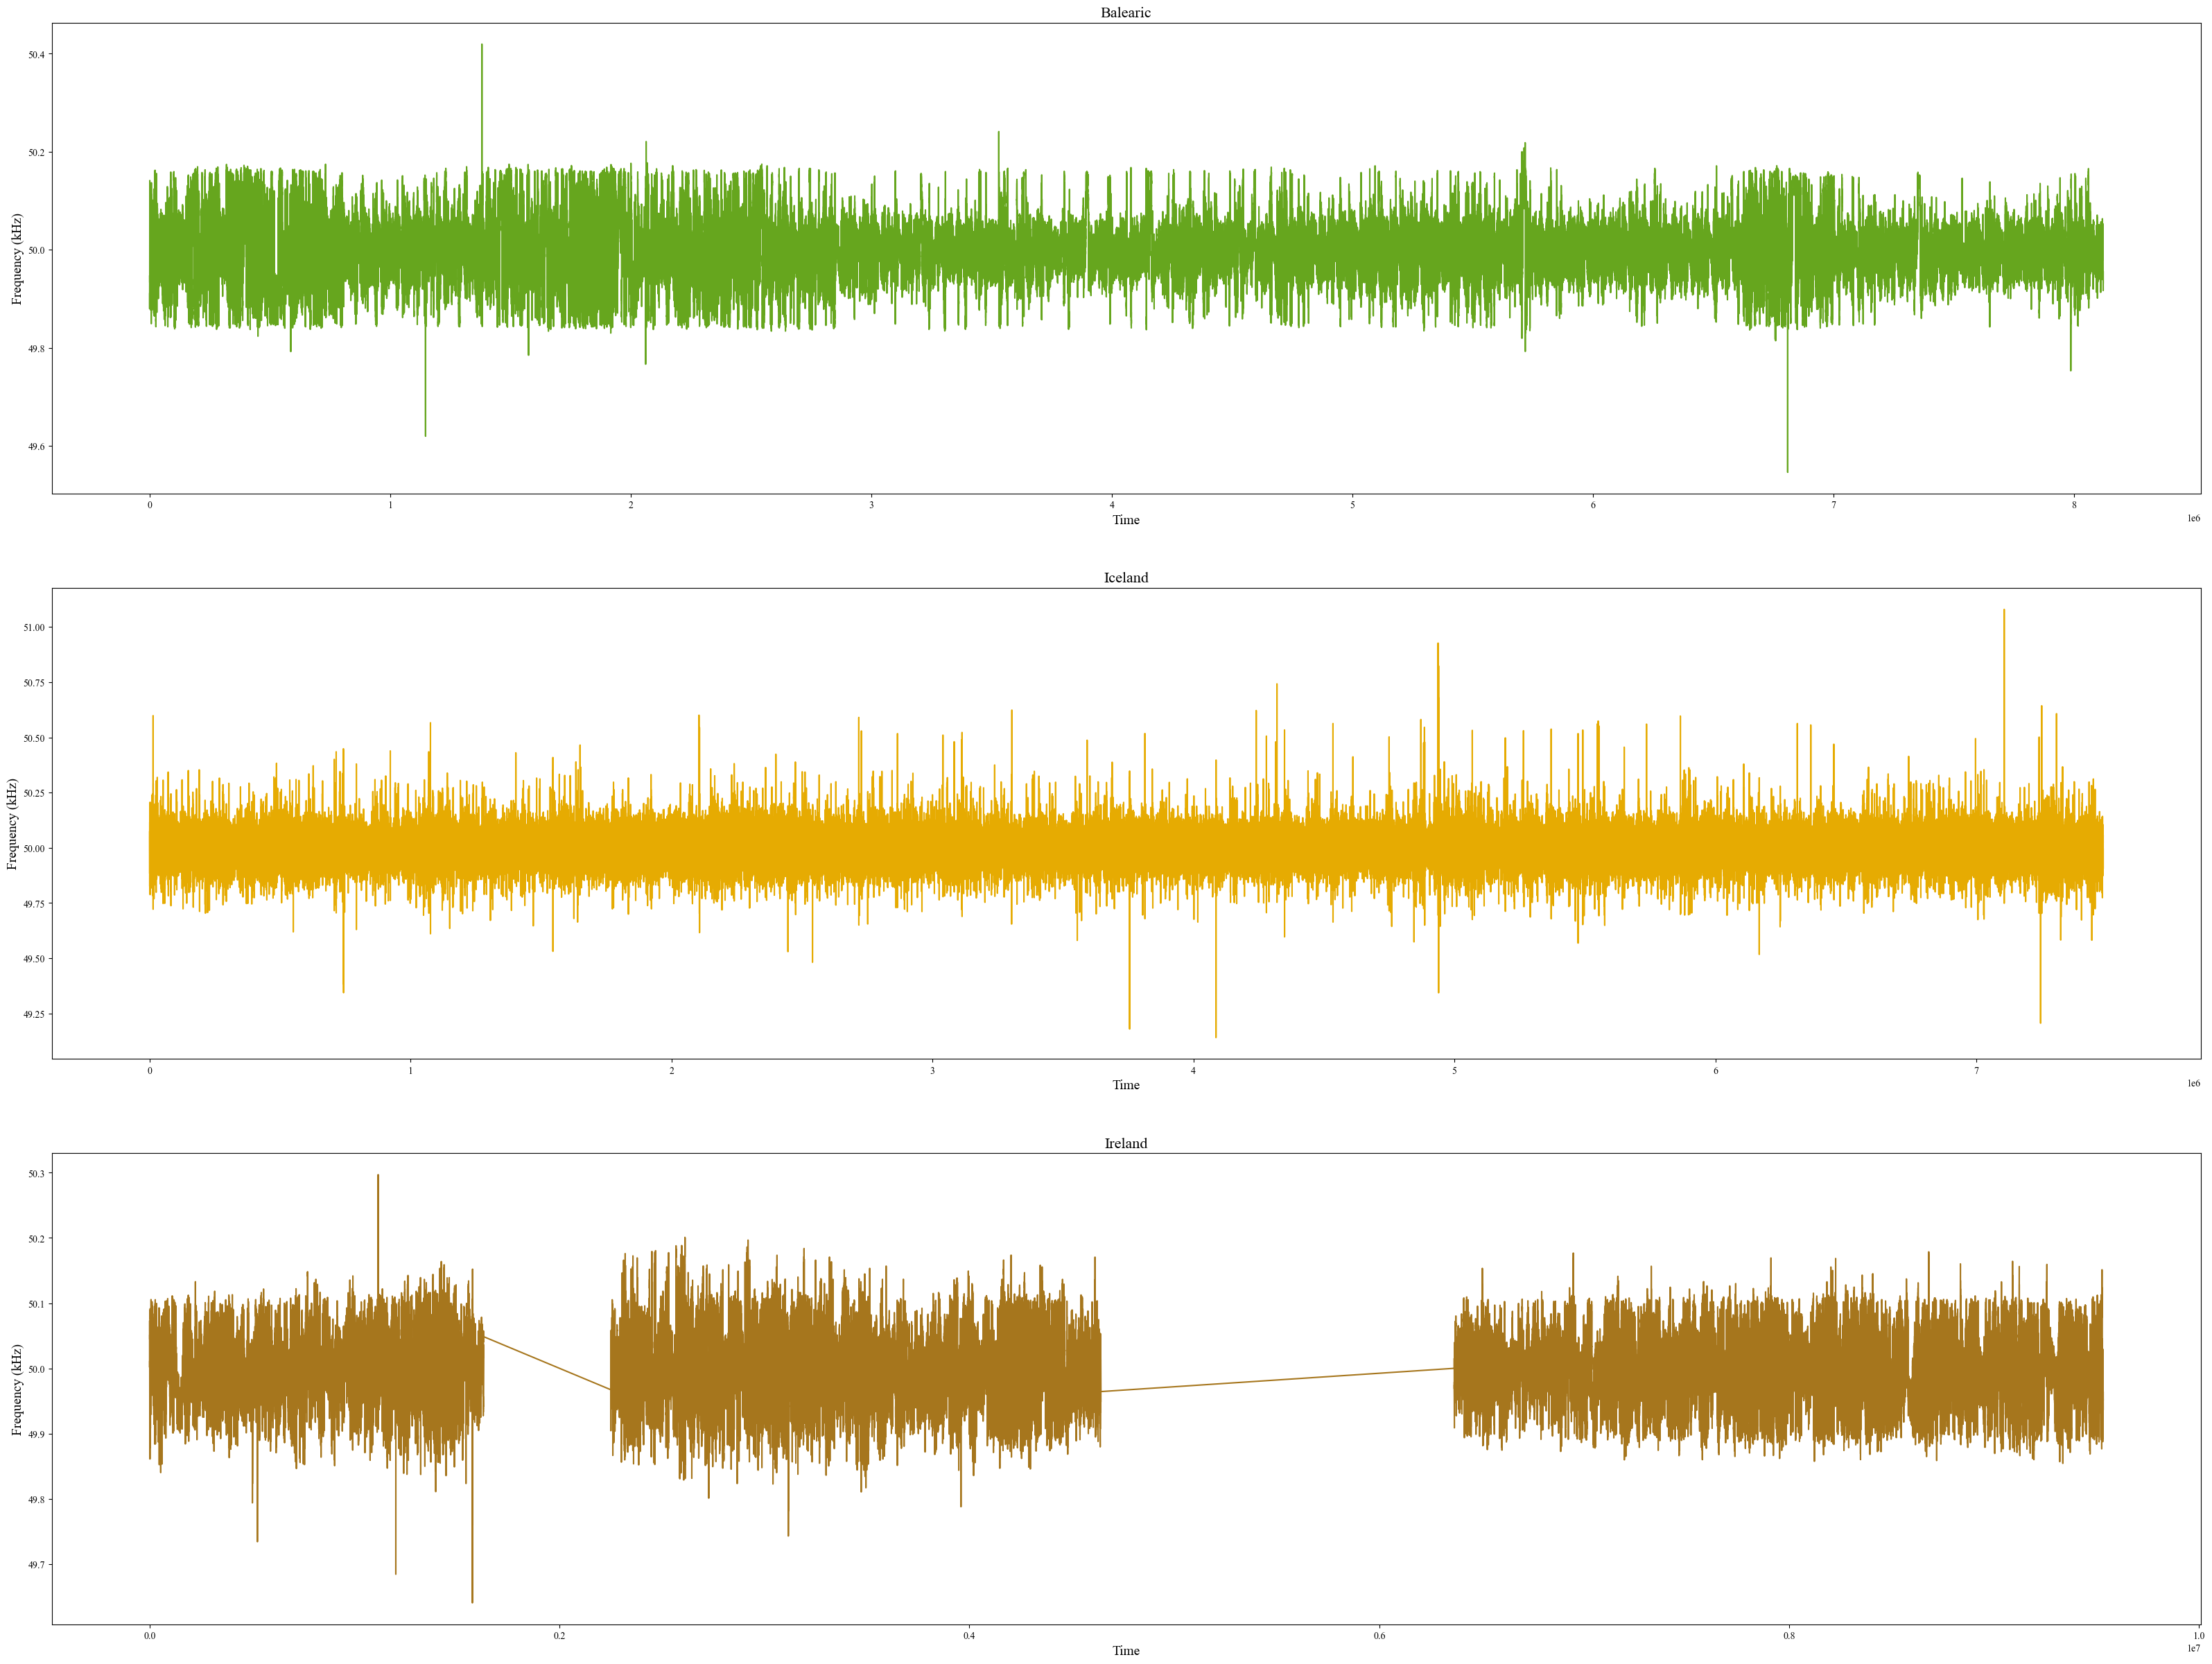

In [72]:
fig, axs = plt.subplots(nrows=len(flt_dataframes), figsize=(40,30))

for i, df in enumerate(flt_dataframes):
    axs[i].plot(df['f50'],color=colors[i])
    axs[i].set_title(region_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)',fontsize=14)

#plt.tight_layout()
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

In [4]:
# Find the longest continuous part for each region
filter_data = []
for df in flt_dataframes:
    # Convert the 'Time' column to datetime type
    df['Time'] = pd.to_datetime(df['Time'])
    time_diff = df['Time'].diff()

    # Find the longest continuous part by grouping consecutive timestamps with the same difference
    groups = (time_diff != pd.Timedelta(seconds=1)).cumsum()
    max_group = groups.value_counts().idxmax()

    # Filter the DataFrame to retain only the longest continuous part
    longest_continuous_df = df[groups == max_group]
    filter_data.append(longest_continuous_df)
    
filter_dict = {0: 'Balearic', 1: 'Iceland', 2: 'Ireland'}

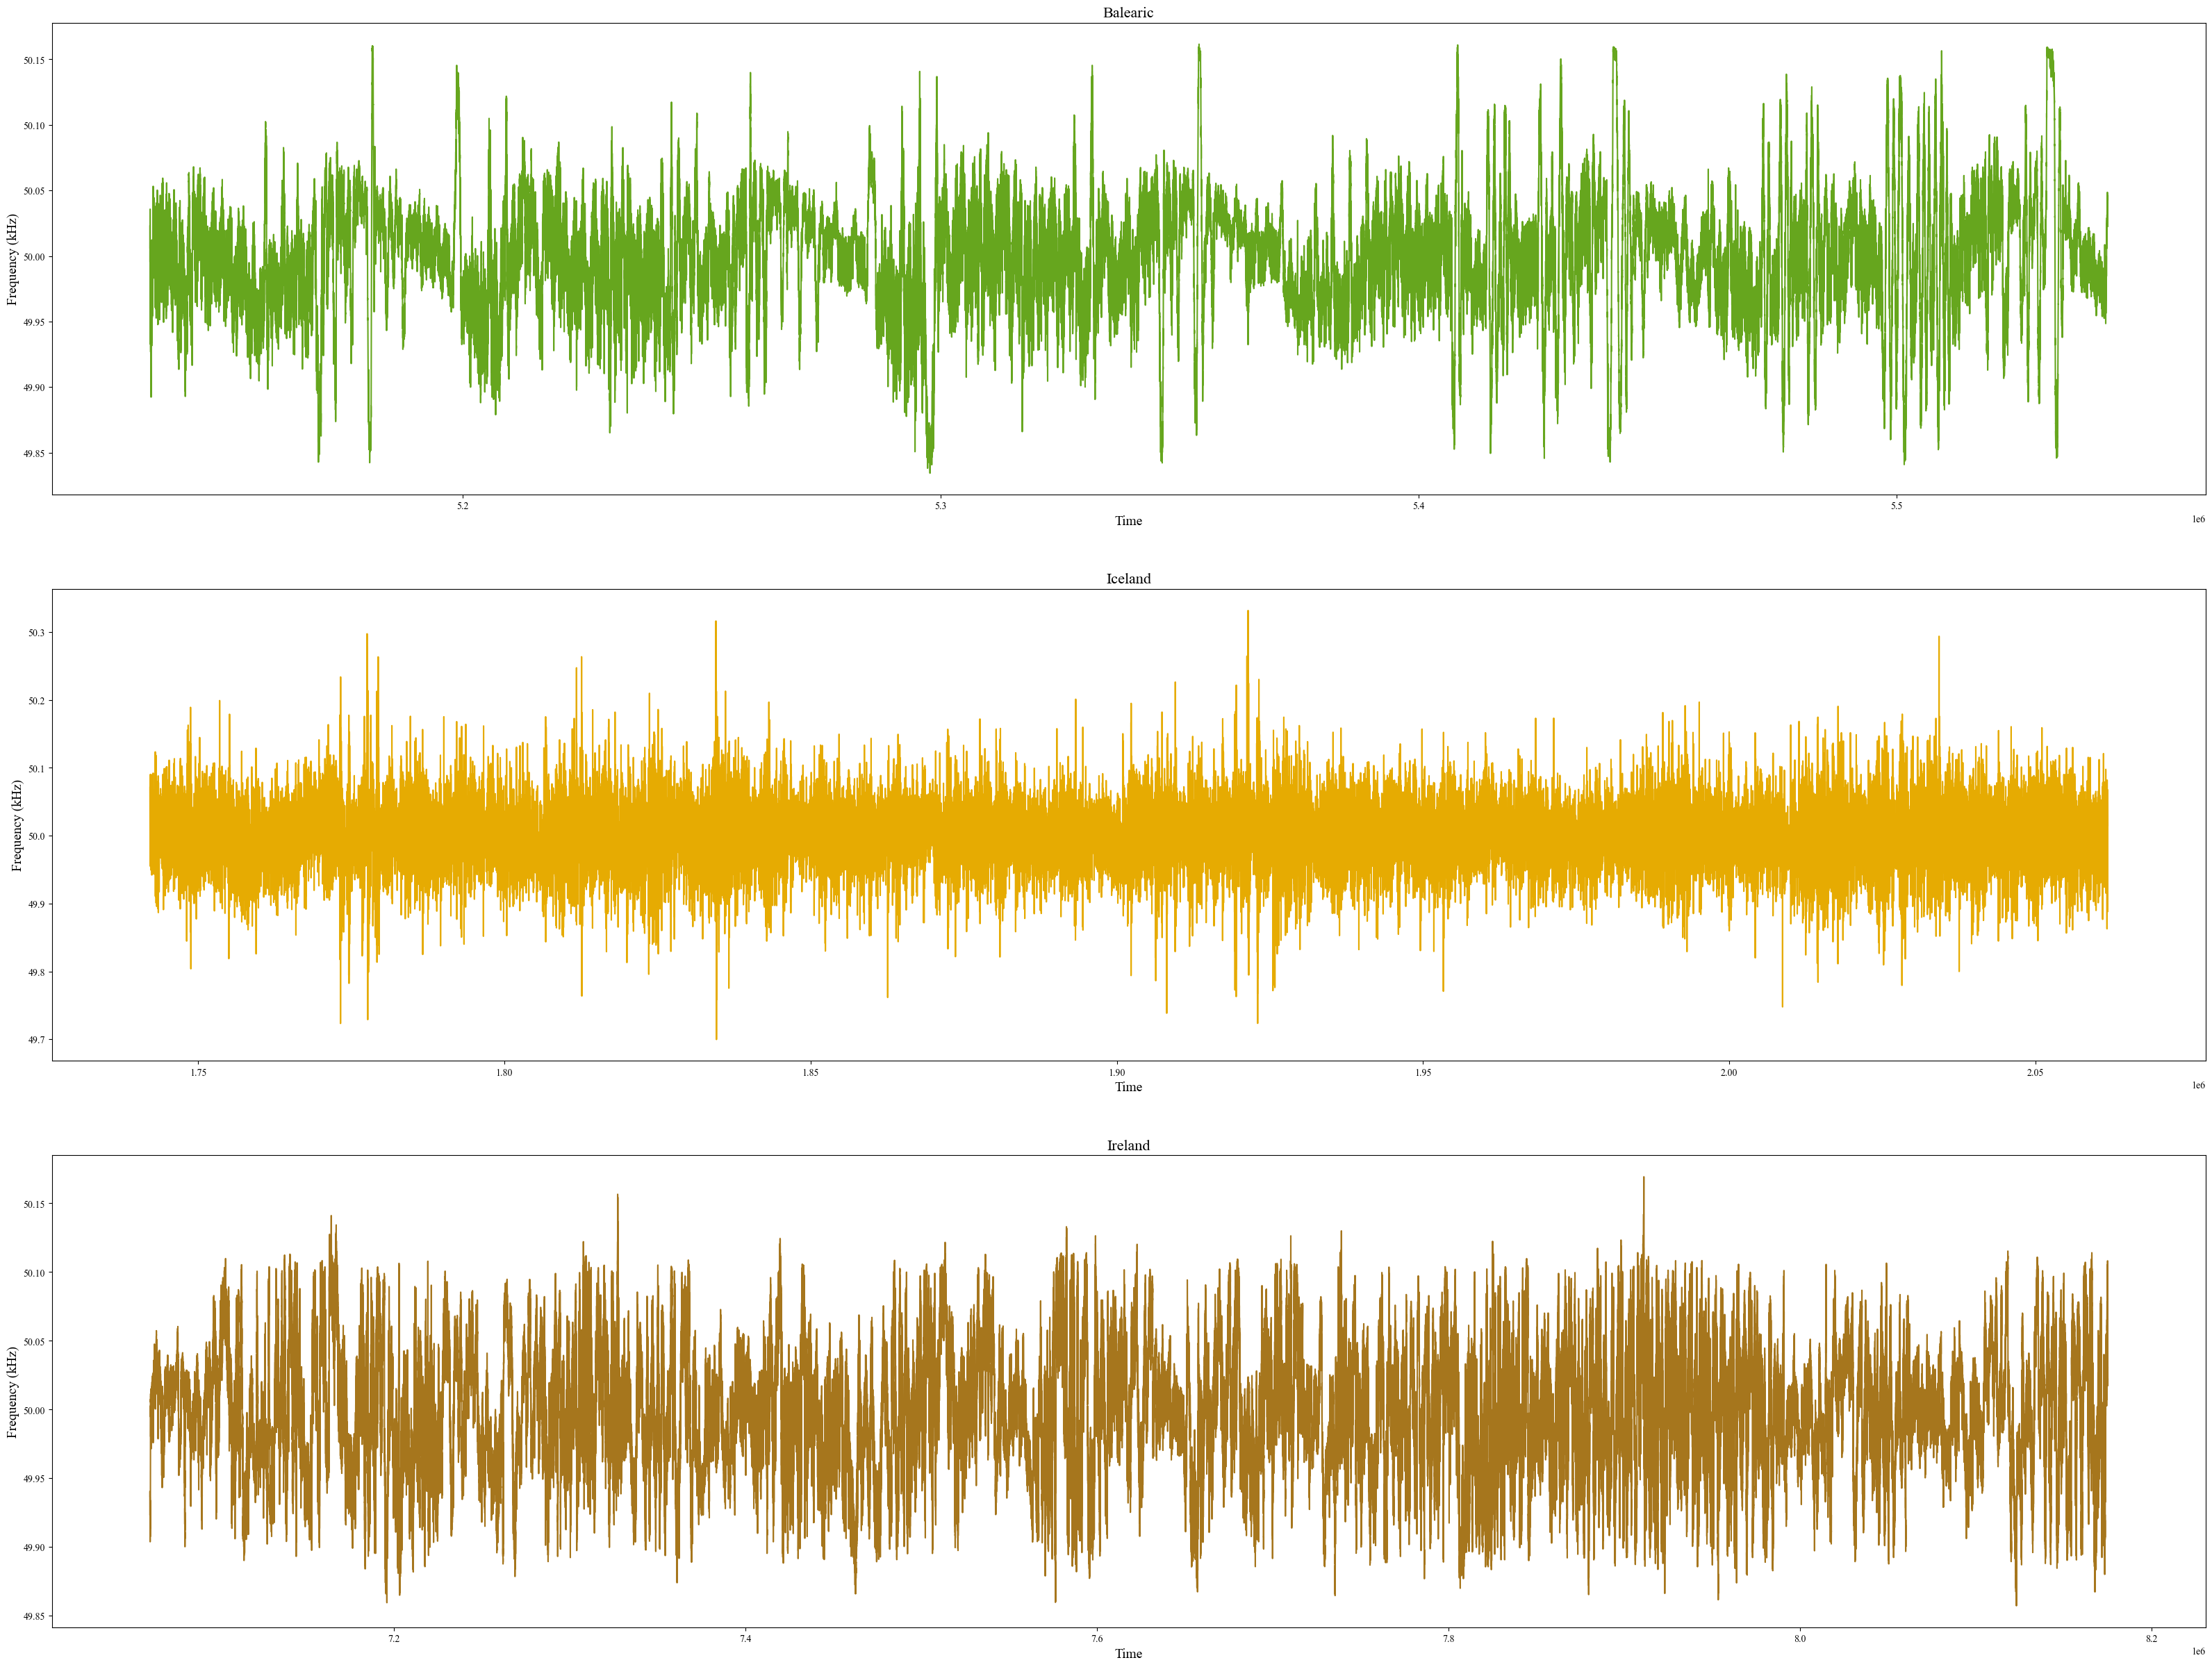

In [18]:
fig, axs = plt.subplots(nrows=len(filter_data), figsize=(40,30))

for i, df in enumerate(filter_data):
    axs[i].plot(df['f50'],color=colors[i])
    axs[i].set_title(region_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)',fontsize=14)

#plt.tight_layout()
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

In [74]:
for i, df in enumerate(filter_data):
    data = df.iloc[:, 1].dropna().values
    result = kpss(data, regression="c", nlags=0)
    test_statistic = result[0]
    p_value = result[1]

    # Assuming a 5% significance level
    critical_value_5percent = result[3]['5%']

    if test_statistic > critical_value_5percent:
        print(f"Region {filter_dict[i]}: Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f} (Non-Stationary)")
    else:
        print(f"Region {filter_dict[i]}: Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f} (Stationary)")



Region Balearic: Test Statistic = 124.6168, p-value = 0.0100 (Non-Stationary)
Region Iceland: Test Statistic = 5.5887, p-value = 0.0100 (Non-Stationary)
Region Ireland: Test Statistic = 52.2583, p-value = 0.0100 (Non-Stationary)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




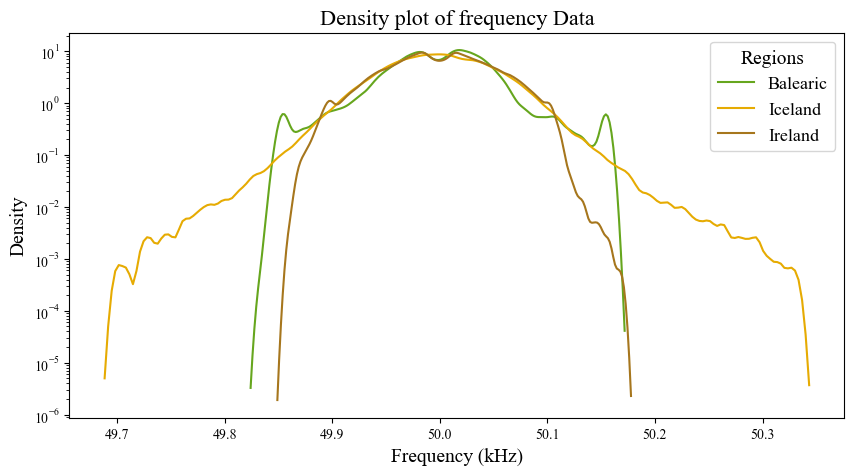

In [67]:
fig, ax = plt.subplots(figsize=(10,5))

for i, df in enumerate(filter_data):
    data = df.iloc[:,1]
    sns.kdeplot(data, color=colors[i], ax=ax, label=region_dict[i])

ax.set_title('Density plot of frequency Data',fontsize=16)
ax.set_xlabel('Frequency (kHz)',fontsize=14)
ax.set_ylabel('Density',fontsize=14)
ax.set_yscale('log') 
#ax.set_xscale('log')

plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')
plt.show()

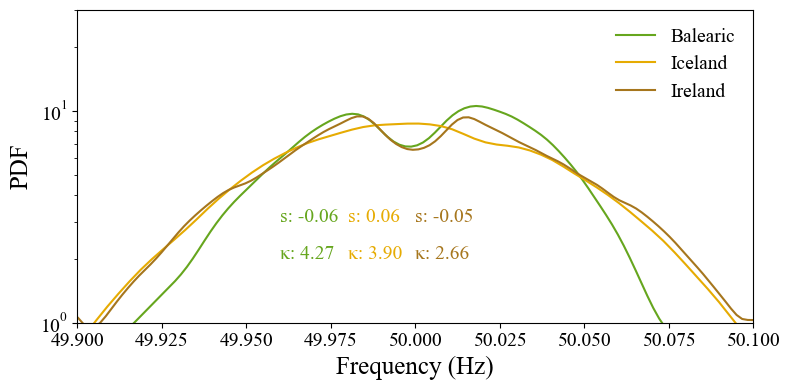

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))


for i, df in enumerate(filter_data):
    data = df['f50']
    sns.kdeplot(data, color=colors[i], ax=ax, label=region_dict[i])
    
skewness = []
kurtosis = []

for df in filter_data:
    skewness.append(df['f50'].skew())
    kurtosis.append(df['f50'].kurtosis() + 3)  

#ax.set_title('Asia-Australia', fontsize=12)
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('PDF', fontsize=18)
ax.set_yscale('log') 
ax.set_xlim([49.9, 50.1])
ax.set_ylim([1, 30])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

s = np.array(skewness)
k = np.array(kurtosis)

for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(49.96+i*0.02, 3, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text(49.96+i*0.02, 2, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)


plt.legend(fontsize=14, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

In [75]:
euro_dip=[]
for i, df in enumerate (filter_data):
    dip,pval = diptest.diptest(df['f50'].astype(float))
    region=region_dict[i]
    euro_dip.append((dip))
%store euro_dip

Stored 'euro_dip' (list)


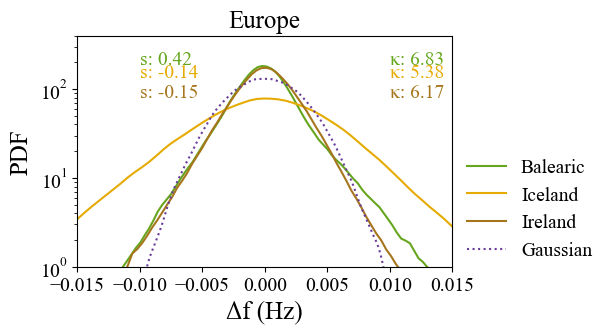

In [92]:
tau=1

fig, ax = plt.subplots(figsize=(6,3))

increment_dfs = []
for i, df in enumerate(filter_data):
    df_copy = df.copy()
    df_copy['increment_freq'] = df_copy.iloc[:,1].diff(periods=tau)
    increment_data = df_copy.dropna()
    increment_dfs.append(increment_data)
    
skewness = []
kurtosis = []

for df in increment_dfs:
    skewness.append(df['increment_freq'].skew())
    kurtosis.append(df['increment_freq'].kurtosis()+3)

# Plot the filtered data inside the loop
for i, df in enumerate(increment_dfs):
    sns.kdeplot(df['increment_freq'], color=colors[i], ax=ax, label=region_dict[i])
    
# Plot normal distribution curve
sns.kdeplot(random.normal(loc=0, scale=0.003,size=100000), color= '#6a3d9a', ax=ax, label='Gaussian',linestyle=":")

ax.set_title('Europe',fontsize=18)
ax.set_xlabel('\u0394f (Hz)',fontsize=18)
ax.set_ylabel('PDF',fontsize=18)
ax.set_yscale('log') 

ax.set_xlim([-0.015,0.015])
ax.set_ylim([1,400])

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

# Add skewness and kurtosis annotations
s = skewness  
k = kurtosis 

for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(-0.01, 190-i*55, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text( 0.01, 190-i*55, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)


#plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(fontsize=14,bbox_to_anchor = (1.42, 0.25), loc='center right',frameon=False)

# Adjust subplot spacing
plt.subplots_adjust(right=0.75)


plt.rcParams.update({'font.family': 'Times New Roman'})
plt.savefig('C:/4. Paper plots/fig 4b.pdf')
#plt.show()


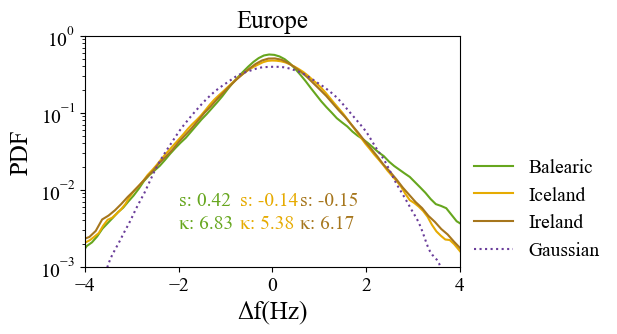

In [9]:
tau = 1

fig, ax = plt.subplots(figsize=(6, 3))

increment_dfs = []

for i, df in enumerate(filter_data):
    df_copy = df.copy()
    df_copy['increment_freq'] = df_copy.iloc[:, 1].diff(periods=tau)
    increment_data = df_copy.dropna().copy()  # Create a copy to avoid SettingWithCopyWarning
    
    # Normalize the increment frequency column to have mean 0 and standard deviation 1
    mean = increment_data['increment_freq'].mean()
    std = increment_data['increment_freq'].std()
    increment_data['normalized_increment_freq'] = (increment_data['increment_freq'] - mean) / std
    
    increment_dfs.append(increment_data)

skewness = []
kurtosis = []

for df in increment_dfs:
    skewness.append(df['normalized_increment_freq'].skew())
    kurtosis.append(df['normalized_increment_freq'].kurtosis() + 3)

# Plot the filtered data inside the loop
for i, df in enumerate(increment_dfs):
    sns.kdeplot(df['normalized_increment_freq'], color=colors[i], ax=ax, label=region_dict[i])

# Plot normal distribution curve
sns.kdeplot(random.normal(loc=0, scale=1, size=100000), color='#6a3d9a', ax=ax, label='Gaussian', linestyle=":")

ax.set_title('Europe', fontsize=18)
ax.set_xlabel('\u0394f(Hz)', fontsize=18)
ax.set_ylabel('PDF', fontsize=18)
ax.set_yscale('log')

ax.set_xlim([-4,4])
ax.set_ylim([1e-3, 1])

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

# Add skewness and kurtosis annotations
s = skewness  
k = kurtosis 

for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(-2+i*1.3, 10**-2.2, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text(-2+i*1.3, 10**-2.5, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)

plt.legend(fontsize=14, bbox_to_anchor=(1.42, 0.25), loc='center right', frameon=False)

# Adjust subplot spacing
plt.subplots_adjust(right=0.75)

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.savefig('C:/4. Paper plots/fig 4b.pdf')
#plt.show()

In [111]:
def LTtest (data):
    # Compute Fourier transform 
    fft_0 = np.fft.fft(data)
    
    # Randomize phases of Fourier coefficients
    rand_phases = np.random.uniform(0, 2*np.pi, size=len(fft_0))
    surrogate = np.abs(fft_0) * np.exp(1j * rand_phases)
    
    # Compute inverse Fourier transform to obtain surrogate data
    surrogate = np.real(np.fft.ifft(surrogate))
    
    data = data[~np.isnan(data)]
    L = len(data)
    
    tau = np.arange(1, 82801,540 )
    #tau = np.arange(0, L//2, 3600)
    res_1 = np.zeros(len(tau))
    res_2 = np.zeros(len(tau))
    surr_1 = np.zeros(len(tau))
    surr_2 = np.zeros(len(tau))

    for i in range(len(tau)):
        x_t = data[0 :L-tau[i]]
        x_tau = data[tau[i]:L]
        y_t = surrogate[0:(L-tau[i])]
        y_tau = surrogate[(tau[i]):L]


        # First method LT1
        res_1[i] = np.mean(x_t**2 * x_tau)-np.mean(x_t * x_tau**2)
        surr_1[i] = np.mean(y_t**2 * y_tau)-np.mean(y_t *y_tau**2)

        # Second method LT2
        res_2[i] = np.mean((x_t-x_tau)**3)/np.mean((x_t-x_tau)**2)
        surr_2[i] = np.mean((y_t-y_tau)**3)/np.mean((y_t-y_tau)**2)
        
    # Calculate the rmse(LT1)
    mse_lt1 = mean_squared_error(np.nan_to_num(res_1), np.nan_to_num(surr_1))
    rmse_lt1 = np.sqrt(mse_lt1)
        
    # Calculate the rmse(LT2)
    mse_lt2 = mean_squared_error(np.nan_to_num(res_2), np.nan_to_num(surr_2))
    rmse_lt2 = np.sqrt(mse_lt2)
    
    #return res_1,surr_1,res_2,surr_2,rmse_lt1,rmse_lt2
    return rmse_lt2

In [112]:
# Calculate LTtest for each dataset in dataframes
euro_lt = []
for i, df in enumerate(filter_data):
    data = df.f50.dropna().values
    rmse_lt2 = LTtest(data)
    euro_lt.append((filter_dict[i], rmse_lt2))
%store euro_lt

Stored 'euro_lt' (list)


In [113]:
euro_lt

[('Balearic', 0.008796455567334317),
 ('Iceland', 0.002202797073890858),
 ('Ireland', 0.0033796971961773405)]

In [96]:
def CKtest (data, tau1, tau2, tau3, bins):
    
    data1 = data[tau1:-tau1] # x3
    data2 = data[tau2:-tau2] # x2
    data3 = data[tau3:-tau3] # x1
    
    # Find bin borders
    dx1 = np.ptp(data3/(bins-1))  # the difference between max and min of data
    dx2 = np.ptp(data2)/(bins-1)
    dx3 = np.ptp(data1)/(bins-1)
    x1 = np.arange(min(data3), np.max(data3)+dx1, dx1)
    x2 = np.arange(min(data2), np.max(data2)+dx2, dx2)
    x3 = np.arange(min(data1), np.max(data1)+dx3, dx3)
    dA = dx1 * dx2
    dV = dx1 * dx2 * dx3
    
    # Finding 2D conditional PDF P(Xt|X(t-1)) or P(x1|x2)
    X = np.column_stack((data3[:len(data3)], data2[:len(data3)]))
    count, edges = np.histogramdd(X, bins=[x1, x2])
    p_12_ref = count/(len(X)*dA)  # Joint PDF of x1, x2
    
    # Calculate p_2
    p_2 = np.zeros(bins-1) # 1d PDF P(x2)
    
    for j in range(bins-1):
        p_2[j] = np.sum(p_12_ref[j,:]) * dx1
        
        # Initialize p_1_2
        p_1_2 = np.zeros((bins-1, bins-1))
        
    # Calculate conditional PDF p_1_2
    for j in range(bins-1):
        if p_2[j] > 0:
            p_1_2[:,j] = p_12_ref[:,j] / p_2[j]

            
    # Set values less than 1e-3 to zero
    p_1_2[p_1_2 < 1e-3] = 0
    
    #Finding 3D conditional PDF P(X_t|X_(t-1),X_(t-2)) or P(x1|x2,x3)
    Y = np.zeros((len(data3), 3))
    Y[:, 0] = data3[:len(data3)]
    Y[:, 1] = data2[:len(data3)]
    Y[:, 2] = data1[:len(data3)]


    edges = (x1, x2, x3)
    count, edges = np.histogramdd(Y, bins=edges)
    mid = [0.5 * (edges[i][1:] + edges[i][:-1]) for i in range(3)]
    loc = np.array(np.unravel_index(np.arange(bins ** 3), (bins, bins, bins)), order='F').T

    # calculate the joint PDF of x2 and x3
    p_123_ref = count / (len(Y) * dV) # % Conditional PDF P(x1|x2,x3)
    p_23 = np.zeros((bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            p_23[i, j] = np.sum(p_123_ref[i, j, :]) * dx1
            
    # calculate the conditional PDF of x1 given x2 and x3
    p_1_23 = np.zeros((bins-1, bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            if p_23[i, j] > 0:
                p_1_23[:, i, j] = p_123_ref[:, i, j] / p_23[i, j]

    
    return x1, x2, p_1_2,p_1_23
    

In [97]:
# Define tau value sets
tau_sets = [
    [2, 4, 6],
    [5,10, 15],
    [20, 40, 60],
    [30, 60, 90],
    [50, 100, 150],
    [70, 140, 210],
    [90, 180, 270],
    [100, 200, 300],
    [200, 400, 600],
    [300, 600, 900],
    [400, 800, 1200],
    [500, 1000, 1500],
    [600, 1200, 1800],
    [700, 1400, 2100],
    [800, 1600, 2400],
    [900, 1800, 2700],
    [1000, 2000, 3000]
    
]

In [98]:
bal_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(filter_data[0].f50.dropna().values, tau[0], tau[1], tau[2], 50)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    bal_distances.append(distance)

In [99]:
ice_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(filter_data[1].f50.dropna().values, tau[0], tau[1], tau[2], 52)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    ice_distances.append(distance)

In [100]:
ire_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(filter_data[2].f50.dropna().values, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    ire_distances.append(distance)

Stored 'euro_dis' (list)


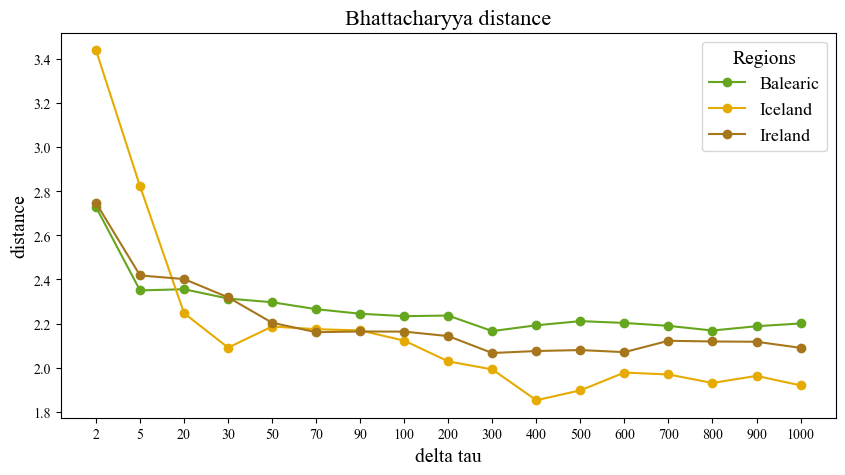

In [102]:
euro_dis=[bal_distances,ice_distances,ire_distances]
%store euro_dis


fig, ax = plt.subplots(figsize=(10,5))

for i, df in enumerate(euro_dis):
    ax.plot(range(len(tau_sets)),df, 'o-',color=colors[i], label=region_dict[i])
    ax.set_title('Bhattacharyya distance',fontsize=16)
    ax.set_xlabel('delta tau',fontsize=14)
    ax.set_ylabel('distance',fontsize=14)

#ax.set_xticklabels([0,2,5,20,30,50,70,90,100], fontsize=12)
plt.xticks(range(len(tau_sets)),[2,5,20,30,50,70,90,100,200,300,400,500,600,700,800,900,1000]) 
plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Slope for Balearic: [1.69106829]
Slope for Iceland: [2.05405112]
Slope for Ireland: [1.6623262]


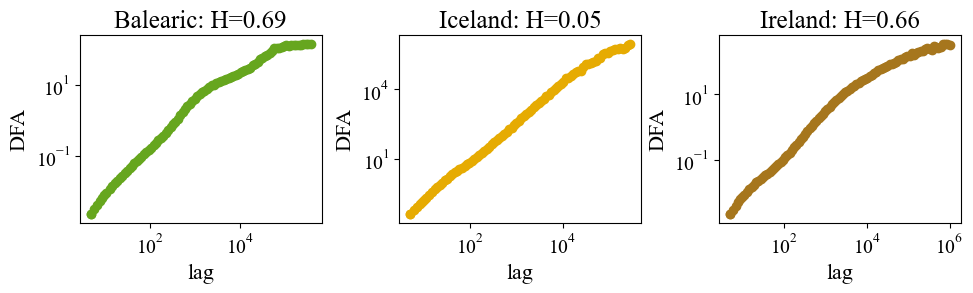

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
fig.tight_layout(pad=3.0)  # Add spacing between subplots

lag = np.logspace(0.7, 6, 100).astype(int)
q = 2
order = 1

for i, df in enumerate(filter_data):
    if i == 1:  # For filter data 2
        lag, dfa = MFDFA(df['f50'].dropna().values, lag=lag, q=q, order=order, modified=True)
        polyfit = np.polyfit(np.log(lag[:10]), np.log(dfa[:10]), 1)
        Hurst = polyfit[0] - 2  # Calculate Hurst exponent for filter data 2
    else:
        lag, dfa = MFDFA(df['f50'].dropna().values, lag=lag, q=q, order=order)
        polyfit = np.polyfit(np.log(lag[:10]), np.log(dfa[:10]), 1)
        Hurst = polyfit[0] - 1  # Calculate Hurst exponent for the rest of the filter data

    ax = axs[i]  # Determine the subplot position
    ax.loglog(lag, dfa, 'o', label='fOU: MFDFA q=2', color=colors[i])
    ax.set_title(f"{region_dict[i]}: H={float(Hurst):.2f}", fontsize=18)
    ax.set_xlabel('lag', fontsize=16)
    ax.set_ylabel('DFA', fontsize=16)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    print(f"Slope for {region_dict[i]}: {polyfit[0]}")

plt.rcParams.update({'font.family': 'Times New Roman'})
#plt.show()
plt.savefig('C:/4. Paper plots/figure 7b.pdf')

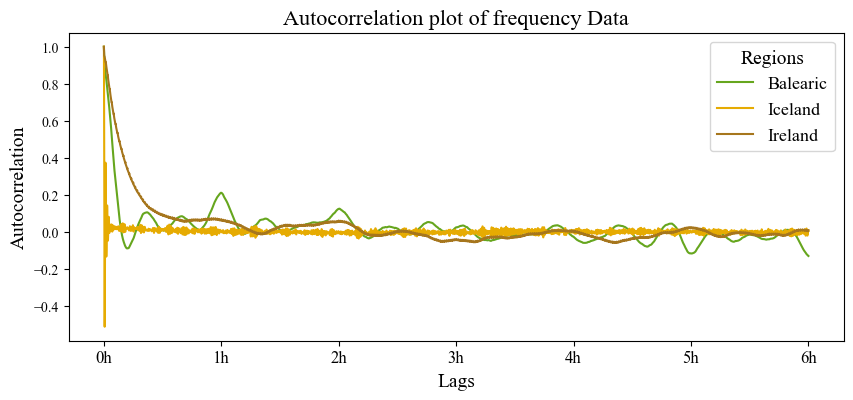

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))

for i, df in enumerate(filter_data):
    data = df.iloc[:, 1]
    acf_vals = acf(data, nlags=3600*6)
    ax.plot(acf_vals, color=colors[i], label=region_dict[i])

ax.set_title('Autocorrelation plot of frequency Data', fontsize=16)
ax.set_xlabel('Lags', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)

ticks = np.arange(0, 3600*7, 3600)
tick_labels = [f'{i//3600}h' for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, fontsize=12)

plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')
plt.show()